In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import itertools
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/monthly-sales-of-company-x-jan-6.csv')
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)
series = df['Count']

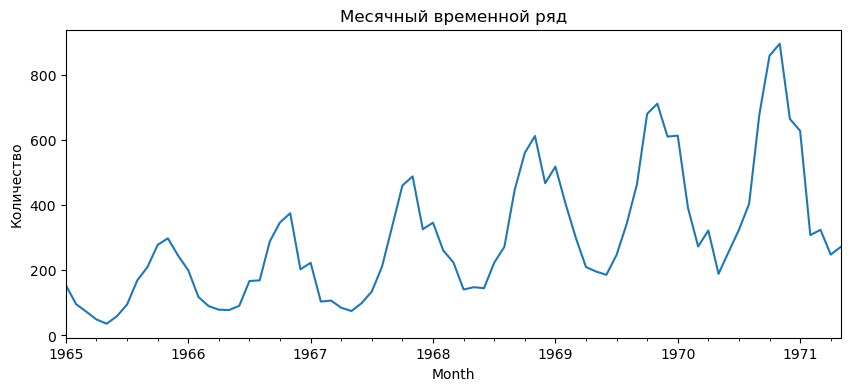

In [3]:
# Визуализация
series.plot(title='Месячный временной ряд', figsize=(10, 4))
plt.ylabel('Количество')
plt.show()

In [4]:
# Тест Дики-Фуллера
result = adfuller(series)
print('ADF статистика: {:.3f}'.format(result[0]))
print('p-значение: {:.3f}'.format(result[1]))

ADF статистика: 0.655
p-значение: 0.989


In [5]:
# Разностное преобразование
series_diff = series.diff().dropna()
result_diff = adfuller(series_diff)
print('ADF (1-я разность): {:.3f}'.format(result_diff[0]))
print('p-значение: {:.3f}'.format(result_diff[1]))

ADF (1-я разность): -2.588
p-значение: 0.096


In [6]:
# Поиск лучшего порядка модели
p_values = range(0, 4)
d = 1
q_values = range(0, 4)
results = []

In [7]:
print('Поиск ARIMA(p,d,q)...')
for p, q in itertools.product(p_values, q_values):
    try:
        model = ARIMA(series, order=(p, d, q))
        fitted = model.fit()
        results.append(((p, d, q), fitted.aic))
        print(f"ARIMA({p},{d},{q}) AIC = {fitted.aic:.2f}")
    except Exception as e:
        print(f"ARIMA({p},{d},{q}) ошибка: {e}")

order_aic = sorted(results, key=lambda x: x[1])
print('\nЛучшие 5 моделей по AIC:')
for order, aic in order_aic[:5]:
    print(f"Порядок={order}, AIC={aic:.2f}")

Поиск ARIMA(p,d,q)...
ARIMA(0,1,0) AIC = 916.50
ARIMA(0,1,1) AIC = 913.88
ARIMA(0,1,2) AIC = 903.30
ARIMA(0,1,3) AIC = 903.54
ARIMA(1,1,0) AIC = 911.13
ARIMA(1,1,1) AIC = 911.88
ARIMA(1,1,2) AIC = 903.95
ARIMA(1,1,3) AIC = 905.41
ARIMA(2,1,0) AIC = 908.95
ARIMA(2,1,1) AIC = 908.71
ARIMA(2,1,2) AIC = 897.93
ARIMA(2,1,3) AIC = 861.19
ARIMA(3,1,0) AIC = 904.69
ARIMA(3,1,1) AIC = 881.59
ARIMA(3,1,2) AIC = 858.18
ARIMA(3,1,3) AIC = 898.84

Лучшие 5 моделей по AIC:
Порядок=(3, 1, 2), AIC=858.18
Порядок=(2, 1, 3), AIC=861.19
Порядок=(3, 1, 1), AIC=881.59
Порядок=(2, 1, 2), AIC=897.93
Порядок=(3, 1, 3), AIC=898.84


In [8]:
# Обучение финальной модели
best_order = order_aic[0][0]
print(f"Выбранный порядок: {best_order}")
model_final = ARIMA(series, order=best_order)
fitted_final = model_final.fit()
print(fitted_final.summary())

Выбранный порядок: (3, 1, 2)
                               SARIMAX Results                                
Dep. Variable:                  Count   No. Observations:                   77
Model:                 ARIMA(3, 1, 2)   Log Likelihood                -423.091
Date:                Thu, 22 May 2025   AIC                            858.183
Time:                        17:02:44   BIC                            872.167
Sample:                    01-01-1965   HQIC                           863.772
                         - 05-01-1971                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.3560      0.101     13.491      0.000       1.159       1.553
ar.L2         -0.3706      0.171     -2.173      0.030      -0.705      -0.036
ar.L3         -0.3521  

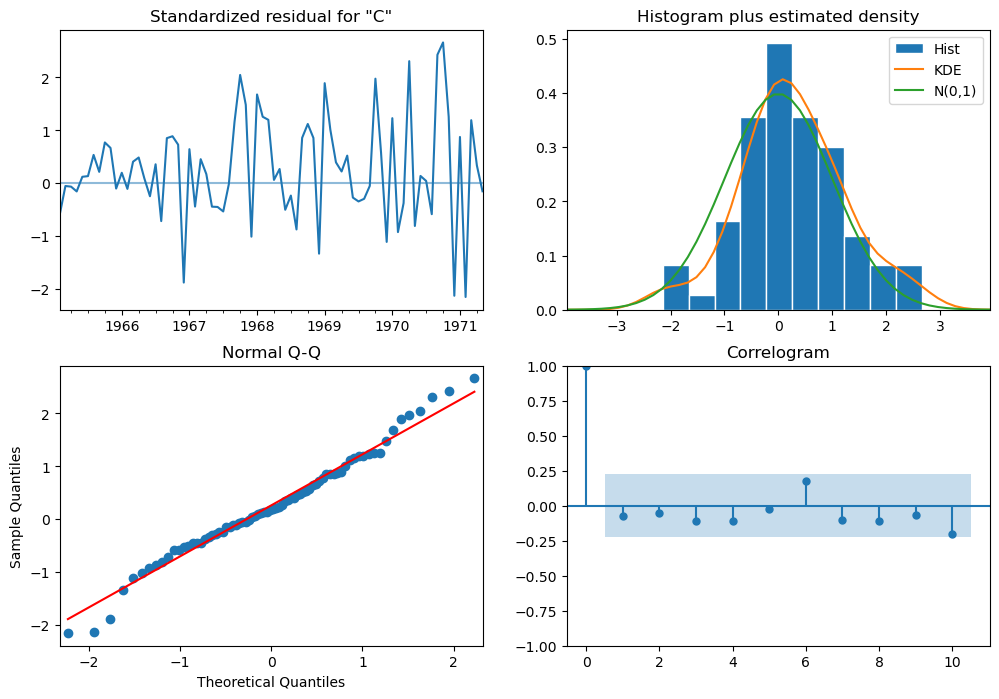

In [9]:
# Диагностика остатков
fitted_final.plot_diagnostics(figsize=(12, 8))
plt.show()

In [10]:
# Прогнозирование
n_steps = 12
forecast = fitted_final.get_forecast(steps=n_steps)
mean_forecast = forecast.predicted_mean
conf_int = forecast.conf_int()

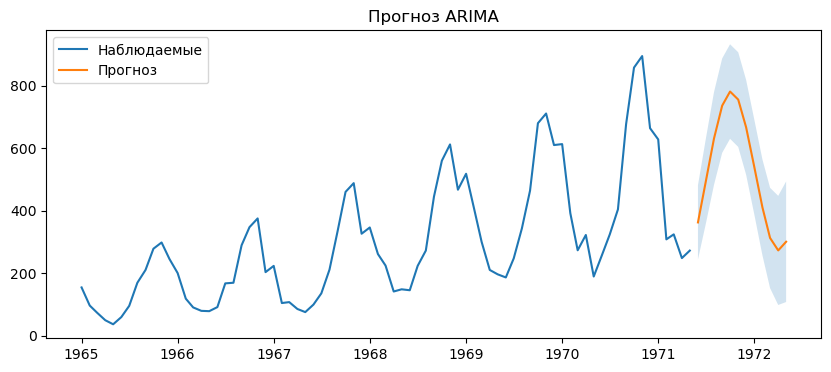

In [11]:
plt.figure(figsize=(10, 4))
plt.plot(series.index, series, label='Наблюдаемые')
forecast_index = pd.date_range(series.index[-1] + pd.DateOffset(months=1), periods=n_steps, freq='MS')
plt.plot(forecast_index, mean_forecast, label='Прогноз')
plt.fill_between(forecast_index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], alpha=0.2)
plt.legend()
plt.title('Прогноз ARIMA')
plt.show()